In [30]:
import sys, os 
import numpy as np
import math
import glob

import matplotlib.pyplot as plt
from itertools import product
import importlib

if importlib.util.find_spec('matplotlib'):
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    matplotlib.font_manager._rebuild()

if importlib.util.find_spec('ipywidgets'):
    from ipywidgets.widgets import IntSlider
    from ipywidgets import interact

In [31]:
# credit to Alper Kamil
def states(gridmap):
    """State generator.

    Yields
    ------
    state: tuple
        State coordinates (i,j).
    """
    n_rows, n_cols = gridmap.shape
    for state in product(range(n_rows),range(n_cols)):
        yield state
        
def plot(gridmap, figsize =12, diff_agent=False,value=None, policy=None, agent=[0,0], dispval=False, save=None, hidden=[], path={}):
        """Plots the values of the states as a color matrix.
        
        Parameters
        ----------
        value : array, shape=(n_mdps,n_qs,n_rows,n_cols) 
            The value function. If it is None, the reward function will be plotted.
            
        policy : array, shape=(n_mdps,n_qs,n_rows,n_cols) 
            The policy to be visualized. It is optional.
            
        agent : tuple
            The position of the agent to be plotted. It is optional.
        
        save : str
            The name of the file the image will be saved to. It is optional
        """
        
        f=FontProperties(weight='bold')
        fontname = 'Times New Roman'
        fontsize = 20
        
        # Up, Down, Right, Left
        A = ['U','D','R','L']  
        
        # Dimensions
        n_rows, n_cols = gridmap.shape

        if value is not None:
            value = np.copy(value)
            for h in hidden:
                value[h] = 0
        
        cmap =plt.cm.RdBu
        # Plot
        fig = plt.figure(figsize=(figsize,figsize))
        plt.rc('text', usetex=True)
        threshold = np.nanmax(np.abs(value))*2 if value is not None else 0
        threshold = 1 if threshold==0 else threshold
        # print(threshold)
        
        if value is None:
            temp = np.zeros(gridmap.shape)
            plt.imshow(temp, interpolation='nearest', cmap=cmap, vmax=threshold, vmin=-threshold)
        else:
            plt.imshow(value, interpolation='nearest', cmap=cmap, vmax=threshold, vmin=-threshold)  
        
        structure = gridmap if gridmap is not None else np.full(gridmap.shape,'E')
        
        # Get the axes
        ax = fig.axes[0]

        # Major ticks
        ax.set_xticks(np.arange(0, n_cols, 1))
        ax.set_yticks(np.arange(0, n_rows, 1))

        # # Labels for major ticks
        # ax.set_xticklabels(np.arange(n_cols+1), fontsize=fontsize)
        # ax.set_yticklabels(np.arange(n_rows+1), fontsize=fontsize)

        # Minor ticks
        ax.set_xticks(np.arange(-.5, n_cols, 1), minor=True)
        ax.set_yticks(np.arange(-.5, n_rows, 1), minor=True)
        
        # Move x axis to the top
        ax.xaxis.tick_top()
    
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=1,alpha=0.5)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        ax.tick_params(bottom='off', left='off')
        
        # Draw the agent
        if agent: 
            if diff_agent:
                # print('diff true')
                circle=plt.Circle((agent[1],agent[0]-0.2),0.26,color='lightgreen',alpha = 0.5, ec='orange',lw=4)
                plt.gcf().gca().add_artist(circle)
            else:
                circle=plt.Circle((agent[1],agent[0]-0.2),0.26,color='lightblue',alpha = 0.5, ec='purple',lw=2)
                plt.gcf().gca().add_artist(circle)

        for i, j in states(gridmap):  # For all states
            if (i,j) in path:
                if 'u' in path[i,j]:
                    rect=plt.Rectangle((j-0.4,i+0.4),+0.8,-0.9,color='lightcoral')
                    plt.gcf().gca().add_artist(rect)
                if 'd' in path[i,j]:
                    rect=plt.Rectangle((j-0.4,i-0.4),+0.8,+0.9,color='lightcoral')
                    plt.gcf().gca().add_artist(rect)
                if 'r' in path[i,j]:
                    rect=plt.Rectangle((j-0.4,i-0.4),+0.9,+0.8,color='lightcoral')
                    plt.gcf().gca().add_artist(rect)
                if 'l' in path[i,j]:
                    rect=plt.Rectangle((j+0.4,i-0.4),-0.9,+0.8,color='lightcoral')
                    plt.gcf().gca().add_artist(rect)
                    
            cell_type = gridmap[i,j]
            
            # If the background is too dark, make the text white
            if value is not None:
                color = 'white' if np.abs(value[i, j]) > threshold/2 else 'black'
            else:        
                color = 'white' if np.abs(temp[i, j]) > threshold/2 else 'black'
            
            if (policy is None and value is not None) or dispval:  # Print the values       
                v = str(value[i,j]).zfill(3)
                plt.text(j, i+0.3, '$'+v+'$',horizontalalignment='center',color=color,fontname=fontname,fontsize=fontsize+2)  # Value
             
            # If there is an obstacle
            if cell_type == 'B':
                circle=plt.Circle((j,i),0.49,color='k',alpha=0.5,fc='darkgray')
                plt.gcf().gca().add_artist(circle)
            
            # If it is a trap cell
            elif cell_type == 'T':
                circle=plt.Circle((j,i),0.49,color='k',fill=False)
                plt.gcf().gca().add_artist(circle)
                
            # If it is a directional cell (See the description of the class attribute 'structure' for details)
            elif cell_type == 'U':
                triangle = plt.Polygon([[j,i],[j-0.5,i+0.5],[j+0.5,i+0.5]],alpha=0.5, color='gray')
                plt.gca().add_patch(triangle)
            elif cell_type == 'D':
                triangle = plt.Polygon([[j,i],[j-0.5,i-0.5],[j+0.5,i-0.5]],alpha=0.5, color='gray')
                plt.gca().add_patch(triangle)
            elif cell_type == 'R':
                triangle = plt.Polygon([[j,i],[j-0.5,i+0.5],[j-0.5,i-0.5]],alpha=0.5, color='gray')
                plt.gca().add_patch(triangle)
            elif cell_type == 'L':
                triangle = plt.Polygon([[j,i],[j+0.5,i+0.5],[j+0.5,i-0.5]],alpha=0.5, color='gray')
                plt.gca().add_patch(triangle)
            
            # Draw the arrows to visualize the policy
            elif (value is None or value[i,j] > 0) and policy is not None:  
                if len(policy[i,j]) >= len(A):
                    plt.text(j, i-0.05,r'$\epsilon_'+str(policy[i,j]-len(A))+'$', horizontalalignment='center',color=color,fontsize=fontsize+5)
                elif not policy[i,j] == 'o':
                    action_name = policy[i,j]
                    #print(action_name)
                    if action_name == 'n':
                        plt.arrow(j,i,0,-0.2,head_width=.2,head_length=.15,color=color)
                    elif action_name == 's':
                        plt.arrow(j,i-.3,0,0.2,head_width=.2,head_length=.15,color=color)
                    elif action_name == 'e':
                        plt.arrow(j-.15,i-0.15,0.2,0,head_width=.2,head_length=.15,color=color)
                    elif action_name == 'w':
                        plt.arrow(j+.15,i-0.15,-0.2,0,head_width=.2,head_length=.15,color=color)
            
            # Plot the labels
            # surplus = 0.2 if (i,j) in hidden else 0
            # if self.label[i,j] in self.lcmap:
            #     circle=plt.Circle((j, i+0.24-surplus),0.2+surplus/2,color=self.lcmap[self.label[i,j]])
            #     plt.gcf().gca().add_artist(circle)
            # if self.label[i,j]:
            #     plt.text(j, i+0.4-surplus,'$'+','.join(self.label[i,j])+'$',horizontalalignment='center',color=color,fontproperties=f,fontname=fontname,fontsize=fontsize+5+surplus*10)
            
        if save:
            plt.savefig(save,bbox_inches='tight')
            
def plot_list(gridmap, value_list,policy_list=None, index = None , alpha_val=None, figsize=8, dispval=True):
        """Plots the list of state values with a slider.
        
        Parameters
        ----------
        value_list : list of arrays with shape=(n_mdps,n_qs,n_rows,n_cols) 
            The list value functions.
            
        policy_list : list of arrays with  shape=(n_mdps,n_qs,n_rows,n_cols) 
            The policy to be visualized. It is optional.
        """
        # A helper function for the slider
        def plot_value(alpha):
            if policy_list is not None:
                print('alpha =:', alpha_val[alpha])
                if index is not None:
                    plot(gridmap,figsize=figsize, value=value_list[index[alpha_val[alpha]]], 
                                                   policy=policy_list[index[alpha_val[alpha]]], dispval=dispval)
                else:
                    plot(gridmap, figsize=figsize, value=value_list[alpha], policy=policy_list[alpha], dispval=dispval)
            else:
                plot(gridmap, value=value_list[alpha], dispval=dispval)
            
        T = value_list.shape[0]
        w=IntSlider(value=0,min=0,max=T-1)
        
        interact(plot_value,alpha=w)  

### Setting Experiment size

In [32]:
exp=900
method ='C51'
print(f'states : {math.sqrt(exp)} *{math.sqrt(exp)}')
if (math.sqrt(exp) < 16):
    display_v = True
    figsize= 10
else:
    figsize= 12
    display_v=False

states : 30.0 *30.0


### Visualizing CVaR results

In [39]:
list_of_files = glob.glob(f'cvar_out_{exp}_{method}_*')    # create the list of file

if len(list_of_files) >0:
    print('files found :', list_of_files)
    alpha2file ={}
    # read all the files :
    list_of_lines = []
    for file_name in list_of_files:
        temp_f = open(file_name, 'r')
        list_of_lines.append(temp_f.readlines())
        temp_f.close()

    # read all the alphas so they can be sorted
    list_of_policies = []
    rows=cols = int(math.sqrt(float(list_of_lines[0][1])))
    nactions = int(list_of_lines[0][7])
    gridmap = np.zeros([rows,cols], dtype=str) 
    policy= np.zeros([len(list_of_files),rows,cols], dtype=str) 
    action_val = np.zeros([len(list_of_files),rows,cols,nactions])
    min_val = np.zeros([len(list_of_files),rows, cols])

    for file_index,Lines in enumerate(list_of_lines):        
        # save alpha
        alpha = float(Lines[5])
        alpha2file[alpha] = file_index 

        list_policy = Lines[3].strip('[]').replace(' ', '').split(',')
        index = 0
        for i in range(rows):
            for j in range(cols):
                if file_index == 0:
                    gridmap[i][j] = 'B' if list_policy[index] == 'obstacle' else 'E'
                policy[file_index][i][j] = list_policy[index]
                index +=1

        temp = Lines[8].strip('[]').replace(' ', '').split(',')
        index = 0
        for i in range(rows):
            for j in range(cols):
                action_val[file_index][i][j] = [float(e) if float(e) !=0 else np.nan for e in temp[index:index+nactions]]
                min_val[file_index][i][j] = np.nanmin(action_val[file_index][i][j])

                index += nactions

files found : ['cvar_out_900_C51_1.0.out', 'cvar_out_900_C51_0.7.out', 'cvar_out_900_C51_0.5.out']


/root/.venvs/csrl/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: All-NaN slice encountered


In [40]:
alpha_val = list(alpha2file.keys())
print(alpha_val)
alpha_val.sort()
alpha_val

[1.0, 0.7, 0.5]


[0.5, 0.7, 1.0]

In [41]:
# print(min_val[alpha2file[1.0]][0][2]) 
print(alpha_val)
plot_list(gridmap, min_val, figsize=figsize, policy_list=policy, alpha_val=alpha_val, index=alpha2file, dispval=display_v)

[0.5, 0.7, 1.0]


interactive(children=(IntSlider(value=0, description='alpha', max=2), Output()), _dom_classes=('widget-interac…

In [7]:
# print(min_val[alpha2file[1.0]][0][2]) 
print(alpha_val)
plot_list(gridmap, min_val, figsize=figsize, policy_list=policy, alpha_val=alpha_val, index=alpha2file, dispval=display_v)
# plot(gridmap, figsize=8, policy =policy)

[0.7]


interactive(children=(IntSlider(value=0, description='alpha', max=0), Output()), _dom_classes=('widget-interac…

### Plotting Traditional VI 

In [46]:
file2= open(f'strat_{exp}.dot', 'r')
Lines2 = file2.readlines()

rows=cols = int(math.sqrt(float(Lines2[1][:-1])))
list_policy2 = Lines2[3].strip('[]').replace(' ', '').split(',')

gridmap2 = np.zeros([rows,cols], dtype=str) 
policy2= np.zeros([rows,cols], dtype=str) 
index2 = 0
for i in range(rows):
    for j in range(cols):
        gridmap2[i][j] = 'B' if list_policy2[index2] == 'obstacle' else 'E'
        policy2[i][j] = list_policy2[index2] if list_policy2[index2] != 'null' else 'z'
        index2 +=1


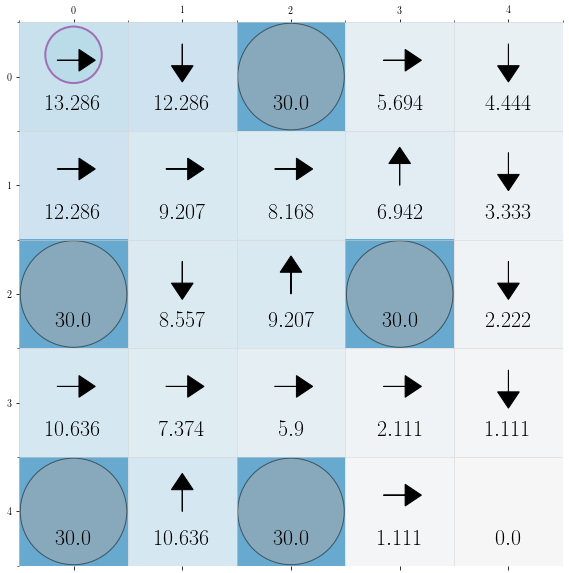

In [48]:
min_val2 = np.zeros([rows, cols])

start_line2 = 6
temp_list= Lines2[start_line2].strip('[]').replace(' ', '').split(',')
index = 0

for i in range(rows):
    # print(temp_list[index:index+cols*2:2])
    min_val2[i] = [float(e) for e in temp_list[index:index+cols]]
    index += cols

plot(gridmap2, figsize=figsize, policy =policy2, value=min_val2, dispval=display_v)      
# plot(gridmap2, figsize=8, policy =policy2)

In [75]:
from scipy.spatial import distance

math.sqrt(math.log(64))

2.039333980337618

In [76]:
math.sqrt(math.log(5))

1.2686362411795196

In [58]:
math.sqrt(2)

1.4142135623730951